In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm

from model.prediction_engine import get_final_data
# final_data = get_final_data(save_to_csv=False)
final_data = pd.read_csv('data/final_data.csv')

In [8]:
import torch
import tensorly as tl
%load_ext autoreload
%autoreload 2

from model.prediction_engine import PredictionTestEngine


final_data = final_data.sort_values(['year_month', 'GVKEY'])
final_data['trt1m'] = pd.to_numeric(final_data['trt1m'], errors='coerce')

# feature columns
feature_cols = [c for c in final_data.columns 
                if c not in ['GVKEY','year_month','trt1m']]
for col in feature_cols:
    final_data[col] = pd.to_numeric(final_data[col], errors='coerce')

# Build Y (T × n_series)
Y_df = (final_data
    .pivot_table(index='year_month', columns='GVKEY', 
                 values='trt1m', aggfunc='mean')
    .sort_index().sort_index(axis=1)
)
Y_df = Y_df.apply(lambda x: (x - x.mean())/x.std(), axis=0)
Y = Y_df.to_numpy()

# Build X tensor (T × n_series × n_features)
X_list = []
for col in feature_cols:
    pivot = (final_data
        .pivot_table(index='year_month', columns='GVKEY', 
                     values=col, aggfunc='mean')
        .reindex(index=Y_df.index, columns=Y_df.columns)
    )
    pivot = pivot.apply(lambda x: (x - x.mean())/x.std(), axis=0)
    X_list.append(pivot.to_numpy())
X = np.stack(X_list, axis=2)

# Shift so that X[t] predicts Y[t+1]
X_all = np.nan_to_num(X[:-1, :, :])
Y_all = np.nan_to_num(Y[1:, :])

# Time index for the test (use first day of month)
time_index_all = pd.to_datetime(Y_df.index[1:], format='%Y-%m')

# Ensure tensorly backend
tl.set_backend("pytorch")
torch.set_default_tensor_type(torch.DoubleTensor)
torch.set_default_dtype(torch.float64)





The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Instantiate engine
window_size = 50
train_start = int(0.95 * X_all.shape[0])
engine = PredictionTestEngine(
    X_all,
    Y_all,
    window_size=window_size,
    train_start=train_start,
    time_index=time_index_all,
)

y_pred, y_true, times, metrics = engine.run(
    method="hopls", R=17, Ln=(20, 20), epsilon=1e-8, verbose=True, n_jobs=5
)

print("Overall metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

# Plot results for series 0
engine.plot_results(series_indices=[0])

Parallel preds: 100%|██████████| 14/14 [00:24<00:00,  1.72s/it]


Overall metrics:
mse: 1.0207
r2: 0.0032
directional_accuracy: 0.5360


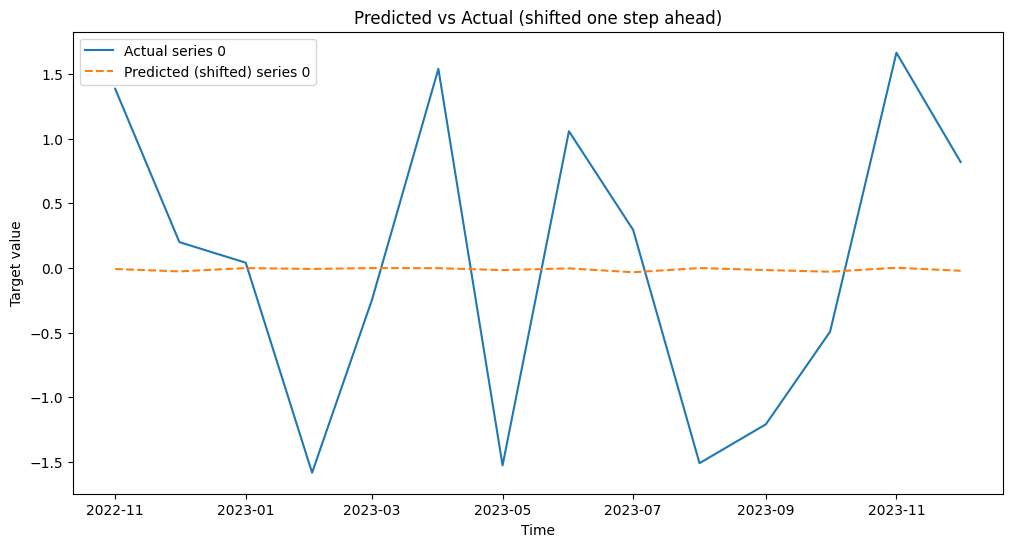

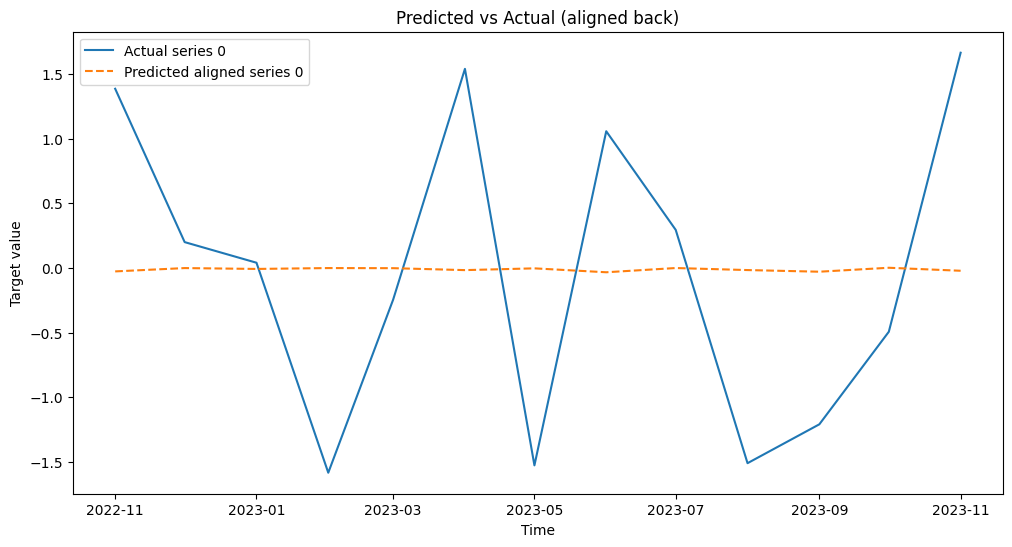

In [ ]:
# Instantiate engine
window_size = 50
train_start = int(0.95 * X_all.shape[0])
engine = PredictionTestEngine(
    X_all,
    Y_all,
    window_size=window_size,
    train_start=train_start,
    time_index=time_index_all,
)

y_pred, y_true, times, metrics = engine.run(
    method="hopls", R=25, Ln=(20, 20), epsilon=1e-7, verbose=True, n_jobs=5
)

print("Overall metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

# Plot results for series 0
engine.plot_results(series_indices=[0])

Parallel preds: 100%|██████████| 195/195 [07:49<00:00,  2.41s/it]


Overall metrics:
mse: 1.0448
r2: -0.0071
directional_accuracy: 0.5132


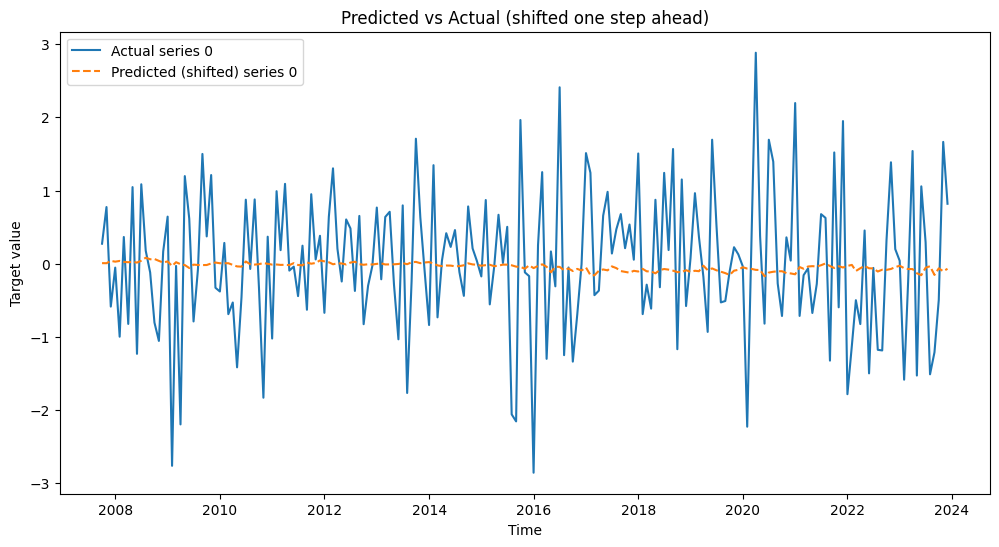

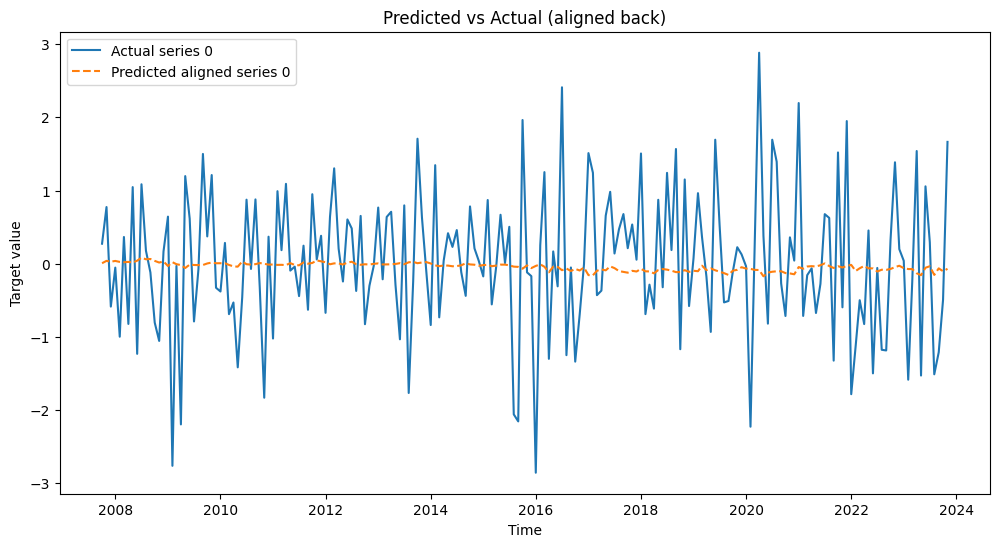

In [ ]:
from model.prediction_engine import PredictionTestEngine
# Instantiate engine
window_size = 80
train_start = int(0.95 * X_all.shape[0])
engine = PredictionTestEngine(
    X_all,
    Y_all,
    window_size=window_size,
    # train_start=train_start,
    time_index=time_index_all,
)

y_pred, y_true, times, metrics = engine.run(
    method="hopls_ridge", R=30, Ln=(4, 4), epsilon=1e-8, verbose=True, n_jobs=5
)

print("Overall metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

# Plot results for series 0
engine.plot_results(series_indices=[0])

Overall metrics:
mse: 1.0411
r2: -0.0035
directional_accuracy: 0.5297


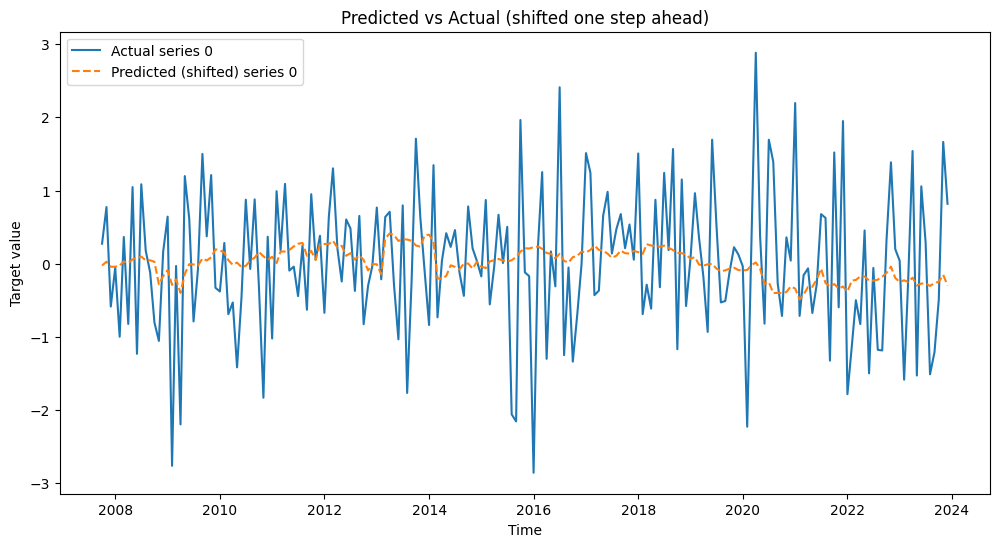

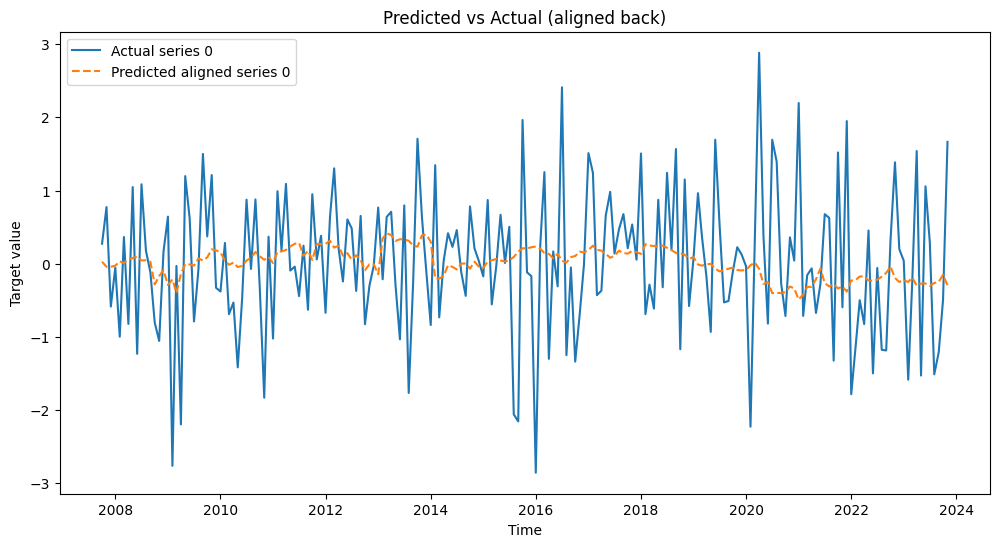

In [ ]:
# Instantiate engine
window_size = 80
train_start = int(0.95 * X_all.shape[0])
engine = PredictionTestEngine(
    X_all, Y_all,
    window_size=window_size,
    # train_start=train_start,
    time_index=time_index_all,
)

y_pred, y_true, times, metrics = engine.run(
    method="ridge", alpha=1.0
)

print("Overall metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

# Plot results for series 0
engine.plot_results(series_indices=[0])

# Grid Search

Running grid search with 150 combinations...
Combination 1/150: window_size=50, R=10, Ln=(2, 2)
  MSE: 1.004122, R2: -0.009890, Directional Accuracy: 0.520997
Combination 2/150: window_size=50, R=10, Ln=(4, 4)
  MSE: 1.000987, R2: -0.006738, Directional Accuracy: 0.524934
Combination 3/150: window_size=50, R=10, Ln=(8, 8)
  MSE: 0.998692, R2: -0.004429, Directional Accuracy: 0.454068
Combination 4/150: window_size=50, R=10, Ln=(15, 15)
  MSE: 0.998413, R2: -0.004148, Directional Accuracy: 0.494751
Combination 5/150: window_size=50, R=10, Ln=(20, 20)
  MSE: 0.997319, R2: -0.003048, Directional Accuracy: 0.463255
Combination 6/150: window_size=50, R=20, Ln=(2, 2)
  MSE: 0.983161, R2: 0.011191, Directional Accuracy: 0.517060
Combination 7/150: window_size=50, R=20, Ln=(4, 4)
  MSE: 1.010977, R2: -0.016785, Directional Accuracy: 0.523622
Combination 8/150: window_size=50, R=20, Ln=(8, 8)
  MSE: 0.996214, R2: -0.001937, Directional Accuracy: 0.515748
Combination 9/150: window_size=50, R=20,

,window_size,R,Ln,mse,r2,directional_accuracy
13,50,30,"(15, 15)",0.994782,-0.000497,0.586614
8,50,20,"(15, 15)",0.994730,-0.000444,0.577428
83,70,60,"(15, 15)",0.991419,0.002886,0.576115
69,70,20,"(20, 20)",0.992314,0.001985,0.573491
78,70,40,"(15, 15)",0.992855,0.001442,0.564304
74,70,30,"(20, 20)",0.993413,0.000880,0.559055
88,70,80,"(15, 15)",0.988886,0.005433,0.547244
127,100,20,"(8, 8)",0.994602,-0.000316,0.545932
124,100,10,"(20, 20)",0.994282,0.000006,0.544619
20,50,60,"(2, 2)",1.008812,-0.014608,0.544619


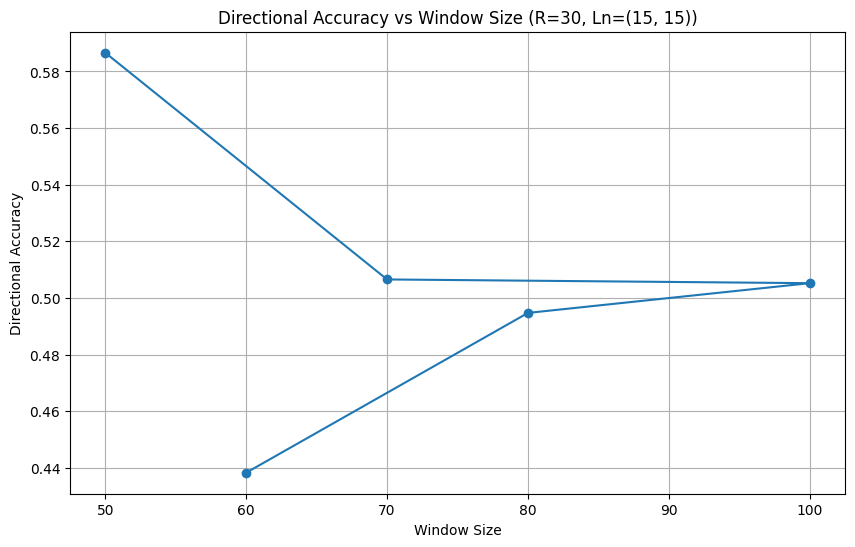

In [ ]:
import json
import pandas as pd
import numpy as np
from time import time
from itertools import product
from model.prediction_engine import PredictionTestEngine
from datetime import datetime
from matplotlib import pyplot as plt

# Define hyperparameter grid
window_sizes = [50, 60, 70, 80, 100]
R_values = [10, 20, 30, 40, 60, 80]
Ln_values = [(2,2), (4,4), (8,8), (15,15), (20,20)]

# Prepare to store results
results = []
epsilon = 1e-8  # Fixed epsilon value
n_jobs = 5     # Use 5 parallel jobs for each model fit

# Start timing
start_time = time()

# Total number of combinations to try
total_combinations = len(window_sizes) * len(R_values) * len(Ln_values)
print(f"Running grid search with {total_combinations} combinations...")

# Counter for progress tracking
counter = 0

# Try all combinations
for window_size, R, Ln in product(window_sizes, R_values, Ln_values):
    counter += 1
    print(f"Combination {counter}/{total_combinations}: window_size={window_size}, R={R}, Ln={Ln}")
    
    # Create a new engine for each window size
    engine = PredictionTestEngine(
        X_all,
        Y_all,
        window_size=window_size,
        train_start=int(0.98 * X_all.shape[0]),  # 95% of data for training
        time_index=time_index_all,
    )
    
    try:
        # Run the model with the current hyperparameters
        _, _, _, metrics = engine.run(
            method="hopls_ridge", 
            R=R, 
            Ln=Ln, 
            epsilon=epsilon, 
            verbose=False,  # Set to True if you want progress bars
            n_jobs=n_jobs
        )
        
        # Store the results
        result = {
            'window_size': window_size,
            'R': R,
            'Ln': Ln,
            'mse': metrics['mse'],
            'r2': metrics['r2'],
            'directional_accuracy': metrics['directional_accuracy']
        }
        results.append(result)
        
        # Print current result
        print(f"  MSE: {metrics['mse']:.6f}, R2: {metrics['r2']:.6f}, "
              f"Directional Accuracy: {metrics['directional_accuracy']:.6f}")
        
    except Exception as e:
        print(f"Error with window_size={window_size}, R={R}, Ln={Ln}: {e}")
        # Continue with next combination

# Calculate total elapsed time
elapsed_time = time() - start_time
print(f"Grid search completed in {elapsed_time:.2f} seconds.")

# Convert results to DataFrame and sort by directional accuracy (descending)
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('directional_accuracy', ascending=False)

# Save results to JSON
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
json_filename = f"hopls_ridge_gridsearch_results_{timestamp}.json"
with open(json_filename, 'w') as f:
    json.dump(results, f, indent=2)
print(f"Results saved to {json_filename}")

# Print top 10 configurations by directional accuracy
print("\nTop 10 configurations by directional accuracy:")
pd.set_option('display.precision', 6)
pd.set_option('display.max_columns', None)
display(results_df.head(10))

# Plot directional accuracy vs window size for the top R and Ln combination
best_R = results_df.iloc[0]['R']
best_Ln = results_df.iloc[0]['Ln']
best_configs = results_df[(results_df['R'] == best_R) & 
                         (results_df['Ln'] == results_df.iloc[0]['Ln'])]

plt.figure(figsize=(10, 6))
plt.plot(best_configs['window_size'], best_configs['directional_accuracy'], 'o-')
plt.title(f'Directional Accuracy vs Window Size (R={best_R}, Ln={best_Ln})')
plt.xlabel('Window Size')
plt.ylabel('Directional Accuracy')
plt.grid(True)
plt.show()

Rolling prediction:   0%|          | 0/225 [00:00<?, ?it/s]

/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  Y_pred.reshape(Y_pred.shape[0], -1)
Rolling prediction: 100%|██████████| 225/225 [15:26<00:00,  4.12s/it]


Overall metrics:
mse: 0.9805
r2: -0.0021
directional_accuracy: 0.4998


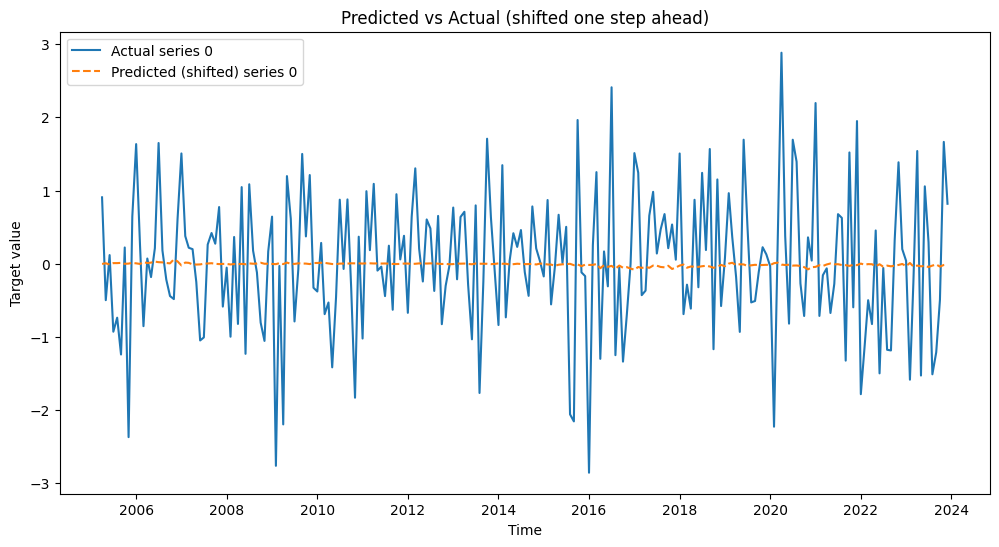

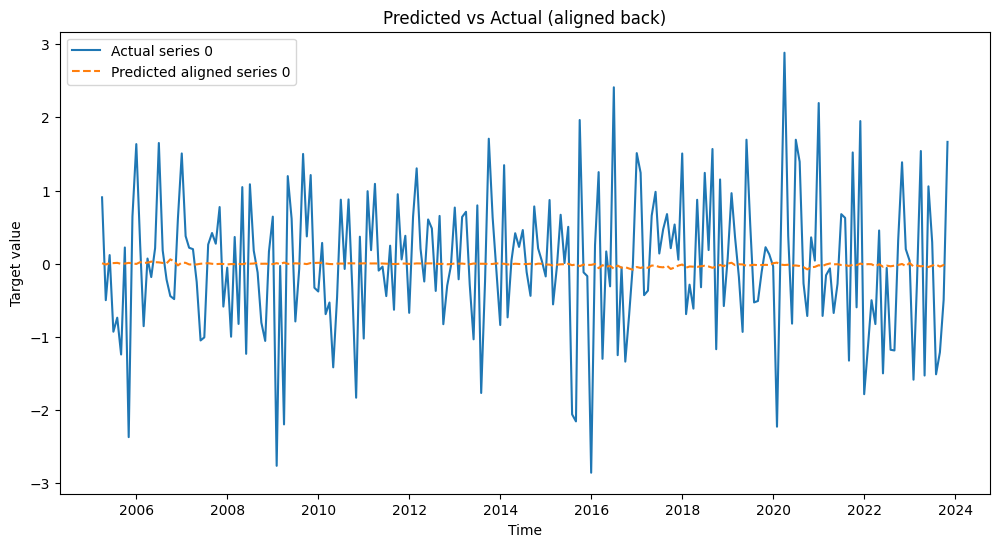

In [9]:
from model.prediction_engine import PredictionTestEngine
# Instantiate engine
window_size = 50
train_start = int(0.95 * X_all.shape[0])
engine = PredictionTestEngine(
    X_all,
    Y_all,
    window_size=window_size,
    # train_start=train_start,
    time_index=time_index_all,
)

y_pred, y_true, times, metrics = engine.run(
    method="hopls", R=20, Ln=(15, 15), epsilon=1e-8, verbose=True, n_jobs=1
)

print("Overall metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

# Plot results for series 0
engine.plot_results(series_indices=[0])

Running grid search with 150 combinations...
Combination 1/150: window_size=50, R=10, Ln=(2, 2)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.007236, R2: -0.013022, Directional Accuracy: 0.519685
Combination 2/150: window_size=50, R=10, Ln=(4, 4)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.005142, R2: -0.010916, Directional Accuracy: 0.535433
Combination 3/150: window_size=50, R=10, Ln=(8, 8)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 0.996060, R2: -0.001781, Directional Accuracy: 0.523622
Combination 4/150: window_size=50, R=10, Ln=(15, 15)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 0.993272, R2: 0.001022, Directional Accuracy: 0.518373
Combination 5/150: window_size=50, R=10, Ln=(20, 20)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 0.989930, R2: 0.004383, Directional Accuracy: 0.498688
Combination 6/150: window_size=50, R=20, Ln=(2, 2)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.027810, R2: -0.033715, Directional Accuracy: 0.511811
Combination 7/150: window_size=50, R=20, Ln=(4, 4)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.009096, R2: -0.014893, Directional Accuracy: 0.530184
Combination 8/150: window_size=50, R=20, Ln=(8, 8)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 0.993849, R2: 0.000442, Directional Accuracy: 0.534121
Combination 9/150: window_size=50, R=20, Ln=(15, 15)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 0.995871, R2: -0.001592, Directional Accuracy: 0.520997
Combination 10/150: window_size=50, R=20, Ln=(20, 20)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 0.991896, R2: 0.002406, Directional Accuracy: 0.547244
Combination 11/150: window_size=50, R=30, Ln=(2, 2)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.088612, R2: -0.094865, Directional Accuracy: 0.518373
Combination 12/150: window_size=50, R=30, Ln=(4, 4)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.035636, R2: -0.041586, Directional Accuracy: 0.528871
Combination 13/150: window_size=50, R=30, Ln=(8, 8)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 0.993728, R2: 0.000563, Directional Accuracy: 0.530184
Combination 14/150: window_size=50, R=30, Ln=(15, 15)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 0.995839, R2: -0.001560, Directional Accuracy: 0.519685
Combination 15/150: window_size=50, R=30, Ln=(20, 20)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 0.991621, R2: 0.002683, Directional Accuracy: 0.531496
Combination 16/150: window_size=50, R=40, Ln=(2, 2)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.080737, R2: -0.086945, Directional Accuracy: 0.509186
Combination 17/150: window_size=50, R=40, Ln=(4, 4)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.063217, R2: -0.069324, Directional Accuracy: 0.501312
Combination 18/150: window_size=50, R=40, Ln=(8, 8)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 0.991323, R2: 0.002983, Directional Accuracy: 0.528871
Combination 19/150: window_size=50, R=40, Ln=(15, 15)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 0.998818, R2: -0.004556, Directional Accuracy: 0.519685
Combination 20/150: window_size=50, R=40, Ln=(20, 20)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 0.995251, R2: -0.000968, Directional Accuracy: 0.523622
Combination 21/150: window_size=50, R=60, Ln=(2, 2)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.131232, R2: -0.137731, Directional Accuracy: 0.520997
Combination 22/150: window_size=50, R=60, Ln=(4, 4)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.109852, R2: -0.116228, Directional Accuracy: 0.494751
Combination 23/150: window_size=50, R=60, Ln=(8, 8)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 0.993395, R2: 0.000898, Directional Accuracy: 0.531496
Combination 24/150: window_size=50, R=60, Ln=(15, 15)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.009894, R2: -0.015695, Directional Accuracy: 0.511811
Combination 25/150: window_size=50, R=60, Ln=(20, 20)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 0.999299, R2: -0.005040, Directional Accuracy: 0.524934
Combination 26/150: window_size=50, R=80, Ln=(2, 2)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.180239, R2: -0.187019, Directional Accuracy: 0.530184
Combination 27/150: window_size=50, R=80, Ln=(4, 4)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.116172, R2: -0.122584, Directional Accuracy: 0.484252
Combination 28/150: window_size=50, R=80, Ln=(8, 8)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 0.986522, R2: 0.007811, Directional Accuracy: 0.536745
Combination 29/150: window_size=50, R=80, Ln=(15, 15)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.010096, R2: -0.015898, Directional Accuracy: 0.511811
Combination 30/150: window_size=50, R=80, Ln=(20, 20)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 0.994799, R2: -0.000514, Directional Accuracy: 0.526247
Combination 31/150: window_size=60, R=10, Ln=(2, 2)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.034096, R2: -0.040036, Directional Accuracy: 0.523622
Combination 32/150: window_size=60, R=10, Ln=(4, 4)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.001483, R2: -0.007236, Directional Accuracy: 0.439633
Combination 33/150: window_size=60, R=10, Ln=(8, 8)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.003064, R2: -0.008826, Directional Accuracy: 0.334646
Combination 34/150: window_size=60, R=10, Ln=(15, 15)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.003902, R2: -0.009669, Directional Accuracy: 0.425197
Combination 35/150: window_size=60, R=10, Ln=(20, 20)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 0.999450, R2: -0.005192, Directional Accuracy: 0.437008
Combination 36/150: window_size=60, R=20, Ln=(2, 2)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.039539, R2: -0.045510, Directional Accuracy: 0.519685
Combination 37/150: window_size=60, R=20, Ln=(4, 4)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.015487, R2: -0.021321, Directional Accuracy: 0.476378
Combination 38/150: window_size=60, R=20, Ln=(8, 8)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.007218, R2: -0.013004, Directional Accuracy: 0.413386
Combination 39/150: window_size=60, R=20, Ln=(15, 15)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.004157, R2: -0.009925, Directional Accuracy: 0.350394
Combination 40/150: window_size=60, R=20, Ln=(20, 20)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 0.998680, R2: -0.004417, Directional Accuracy: 0.492126
Combination 41/150: window_size=60, R=30, Ln=(2, 2)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.046564, R2: -0.052576, Directional Accuracy: 0.517060
Combination 42/150: window_size=60, R=30, Ln=(4, 4)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.010232, R2: -0.016036, Directional Accuracy: 0.535433
Combination 43/150: window_size=60, R=30, Ln=(8, 8)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.003164, R2: -0.008926, Directional Accuracy: 0.443570
Combination 44/150: window_size=60, R=30, Ln=(15, 15)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.005077, R2: -0.010850, Directional Accuracy: 0.349081
Combination 45/150: window_size=60, R=30, Ln=(20, 20)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.001533, R2: -0.007287, Directional Accuracy: 0.473753
Combination 46/150: window_size=60, R=40, Ln=(2, 2)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.078923, R2: -0.085121, Directional Accuracy: 0.514436
Combination 47/150: window_size=60, R=40, Ln=(4, 4)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.037987, R2: -0.043950, Directional Accuracy: 0.520997
Combination 48/150: window_size=60, R=40, Ln=(8, 8)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.002088, R2: -0.007845, Directional Accuracy: 0.475066
Combination 49/150: window_size=60, R=40, Ln=(15, 15)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.002590, R2: -0.008349, Directional Accuracy: 0.413386
Combination 50/150: window_size=60, R=40, Ln=(20, 20)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.000707, R2: -0.006456, Directional Accuracy: 0.438320
Combination 51/150: window_size=60, R=60, Ln=(2, 2)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.141004, R2: -0.147559, Directional Accuracy: 0.503937
Combination 52/150: window_size=60, R=60, Ln=(4, 4)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.061089, R2: -0.067184, Directional Accuracy: 0.524934
Combination 53/150: window_size=60, R=60, Ln=(8, 8)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.003514, R2: -0.009279, Directional Accuracy: 0.468504
Combination 54/150: window_size=60, R=60, Ln=(15, 15)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.007153, R2: -0.012938, Directional Accuracy: 0.414698
Combination 55/150: window_size=60, R=60, Ln=(20, 20)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.004099, R2: -0.009867, Directional Accuracy: 0.438320
Combination 56/150: window_size=60, R=80, Ln=(2, 2)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.145987, R2: -0.152570, Directional Accuracy: 0.498688
Combination 57/150: window_size=60, R=80, Ln=(4, 4)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.072543, R2: -0.078705, Directional Accuracy: 0.514436
Combination 58/150: window_size=60, R=80, Ln=(8, 8)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 0.993787, R2: 0.000504, Directional Accuracy: 0.500000
Combination 59/150: window_size=60, R=80, Ln=(15, 15)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.006259, R2: -0.012039, Directional Accuracy: 0.475066
Combination 60/150: window_size=60, R=80, Ln=(20, 20)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.000161, R2: -0.005906, Directional Accuracy: 0.503937
Combination 61/150: window_size=70, R=10, Ln=(2, 2)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.000873, R2: -0.006622, Directional Accuracy: 0.527559
Combination 62/150: window_size=70, R=10, Ln=(4, 4)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.007269, R2: -0.013056, Directional Accuracy: 0.442257
Combination 63/150: window_size=70, R=10, Ln=(8, 8)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 0.998695, R2: -0.004432, Directional Accuracy: 0.393701
Combination 64/150: window_size=70, R=10, Ln=(15, 15)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 0.996875, R2: -0.002602, Directional Accuracy: 0.437008
Combination 65/150: window_size=70, R=10, Ln=(20, 20)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 0.997146, R2: -0.002875, Directional Accuracy: 0.451444
Combination 66/150: window_size=70, R=20, Ln=(2, 2)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 0.979131, R2: 0.015245, Directional Accuracy: 0.527559
Combination 67/150: window_size=70, R=20, Ln=(4, 4)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.015397, R2: -0.021230, Directional Accuracy: 0.519685
Combination 68/150: window_size=70, R=20, Ln=(8, 8)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 0.995082, R2: -0.000798, Directional Accuracy: 0.520997
Combination 69/150: window_size=70, R=20, Ln=(15, 15)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 0.993247, R2: 0.001047, Directional Accuracy: 0.528871
Combination 70/150: window_size=70, R=20, Ln=(20, 20)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.003927, R2: -0.009694, Directional Accuracy: 0.406824
Combination 71/150: window_size=70, R=30, Ln=(2, 2)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.040979, R2: -0.046959, Directional Accuracy: 0.517060
Combination 72/150: window_size=70, R=30, Ln=(4, 4)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.023201, R2: -0.029079, Directional Accuracy: 0.524934
Combination 73/150: window_size=70, R=30, Ln=(8, 8)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 0.990702, R2: 0.003607, Directional Accuracy: 0.526247
Combination 74/150: window_size=70, R=30, Ln=(15, 15)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 0.995207, R2: -0.000924, Directional Accuracy: 0.534121
Combination 75/150: window_size=70, R=30, Ln=(20, 20)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.006520, R2: -0.012302, Directional Accuracy: 0.423885
Combination 76/150: window_size=70, R=40, Ln=(2, 2)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.044403, R2: -0.050403, Directional Accuracy: 0.519685
Combination 77/150: window_size=70, R=40, Ln=(4, 4)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.030993, R2: -0.036915, Directional Accuracy: 0.520997
Combination 78/150: window_size=70, R=40, Ln=(8, 8)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 0.994175, R2: 0.000114, Directional Accuracy: 0.493438
Combination 79/150: window_size=70, R=40, Ln=(15, 15)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 0.994657, R2: -0.000371, Directional Accuracy: 0.527559
Combination 80/150: window_size=70, R=40, Ln=(20, 20)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.009050, R2: -0.014846, Directional Accuracy: 0.443570
Combination 81/150: window_size=70, R=60, Ln=(2, 2)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.100345, R2: -0.106666, Directional Accuracy: 0.524934
Combination 82/150: window_size=70, R=60, Ln=(4, 4)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.069196, R2: -0.075338, Directional Accuracy: 0.518373
Combination 83/150: window_size=70, R=60, Ln=(8, 8)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 0.995532, R2: -0.001251, Directional Accuracy: 0.528871
Combination 84/150: window_size=70, R=60, Ln=(15, 15)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 0.982252, R2: 0.012106, Directional Accuracy: 0.526247
Combination 85/150: window_size=70, R=60, Ln=(20, 20)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.011432, R2: -0.017242, Directional Accuracy: 0.492126
Combination 86/150: window_size=70, R=80, Ln=(2, 2)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.208943, R2: -0.215888, Directional Accuracy: 0.517060
Combination 87/150: window_size=70, R=80, Ln=(4, 4)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.087445, R2: -0.093692, Directional Accuracy: 0.506562
Combination 88/150: window_size=70, R=80, Ln=(8, 8)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 0.988189, R2: 0.006134, Directional Accuracy: 0.559055
Combination 89/150: window_size=70, R=80, Ln=(15, 15)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 0.991182, R2: 0.003124, Directional Accuracy: 0.523622
Combination 90/150: window_size=70, R=80, Ln=(20, 20)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.010293, R2: -0.016096, Directional Accuracy: 0.510499
Combination 91/150: window_size=80, R=10, Ln=(2, 2)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 0.998755, R2: -0.004493, Directional Accuracy: 0.527559
Combination 92/150: window_size=80, R=10, Ln=(4, 4)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.004142, R2: -0.009910, Directional Accuracy: 0.494751
Combination 93/150: window_size=80, R=10, Ln=(8, 8)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 0.995136, R2: -0.000852, Directional Accuracy: 0.479003
Combination 94/150: window_size=80, R=10, Ln=(15, 15)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 0.994629, R2: -0.000343, Directional Accuracy: 0.515748
Combination 95/150: window_size=80, R=10, Ln=(20, 20)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 0.997476, R2: -0.003206, Directional Accuracy: 0.429134
Combination 96/150: window_size=80, R=20, Ln=(2, 2)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.054489, R2: -0.060547, Directional Accuracy: 0.532808
Combination 97/150: window_size=80, R=20, Ln=(4, 4)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.008237, R2: -0.014028, Directional Accuracy: 0.526247
Combination 98/150: window_size=80, R=20, Ln=(8, 8)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 0.990296, R2: 0.004015, Directional Accuracy: 0.524934
Combination 99/150: window_size=80, R=20, Ln=(15, 15)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 0.997002, R2: -0.002729, Directional Accuracy: 0.456693
Combination 100/150: window_size=80, R=20, Ln=(20, 20)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 0.995170, R2: -0.000886, Directional Accuracy: 0.527559
Combination 101/150: window_size=80, R=30, Ln=(2, 2)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.060376, R2: -0.066467, Directional Accuracy: 0.515748
Combination 102/150: window_size=80, R=30, Ln=(4, 4)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.021147, R2: -0.027013, Directional Accuracy: 0.518373
Combination 103/150: window_size=80, R=30, Ln=(8, 8)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 0.997617, R2: -0.003347, Directional Accuracy: 0.500000
Combination 104/150: window_size=80, R=30, Ln=(15, 15)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 0.997886, R2: -0.003618, Directional Accuracy: 0.502625
Combination 105/150: window_size=80, R=30, Ln=(20, 20)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 0.996194, R2: -0.001917, Directional Accuracy: 0.498688
Combination 106/150: window_size=80, R=40, Ln=(2, 2)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.073030, R2: -0.079194, Directional Accuracy: 0.513123
Combination 107/150: window_size=80, R=40, Ln=(4, 4)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.015375, R2: -0.021208, Directional Accuracy: 0.523622
Combination 108/150: window_size=80, R=40, Ln=(8, 8)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 0.998814, R2: -0.004551, Directional Accuracy: 0.507874
Combination 109/150: window_size=80, R=40, Ln=(15, 15)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 0.997607, R2: -0.003338, Directional Accuracy: 0.515748
Combination 110/150: window_size=80, R=40, Ln=(20, 20)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 0.994779, R2: -0.000494, Directional Accuracy: 0.511811
Combination 111/150: window_size=80, R=60, Ln=(2, 2)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.092210, R2: -0.098484, Directional Accuracy: 0.506562
Combination 112/150: window_size=80, R=60, Ln=(4, 4)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.030616, R2: -0.036537, Directional Accuracy: 0.506562
Combination 113/150: window_size=80, R=60, Ln=(8, 8)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.003535, R2: -0.009300, Directional Accuracy: 0.501312
Combination 114/150: window_size=80, R=60, Ln=(15, 15)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.000023, R2: -0.005768, Directional Accuracy: 0.515748
Combination 115/150: window_size=80, R=60, Ln=(20, 20)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 0.991866, R2: 0.002436, Directional Accuracy: 0.520997
Combination 116/150: window_size=80, R=80, Ln=(2, 2)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.127502, R2: -0.133979, Directional Accuracy: 0.506562
Combination 117/150: window_size=80, R=80, Ln=(4, 4)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.069246, R2: -0.075388, Directional Accuracy: 0.511811
Combination 118/150: window_size=80, R=80, Ln=(8, 8)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.020779, R2: -0.026643, Directional Accuracy: 0.507874
Combination 119/150: window_size=80, R=80, Ln=(15, 15)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.002362, R2: -0.008120, Directional Accuracy: 0.524934
Combination 120/150: window_size=80, R=80, Ln=(20, 20)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 0.992112, R2: 0.002188, Directional Accuracy: 0.528871
Combination 121/150: window_size=100, R=10, Ln=(2, 2)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.003095, R2: -0.008858, Directional Accuracy: 0.520997
Combination 122/150: window_size=100, R=10, Ln=(4, 4)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.000008, R2: -0.005752, Directional Accuracy: 0.530184
Combination 123/150: window_size=100, R=10, Ln=(8, 8)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 0.996818, R2: -0.002544, Directional Accuracy: 0.505249
Combination 124/150: window_size=100, R=10, Ln=(15, 15)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 0.996089, R2: -0.001811, Directional Accuracy: 0.451444
Combination 125/150: window_size=100, R=10, Ln=(20, 20)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 0.995047, R2: -0.000764, Directional Accuracy: 0.510499
Combination 126/150: window_size=100, R=20, Ln=(2, 2)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.017520, R2: -0.023365, Directional Accuracy: 0.524934
Combination 127/150: window_size=100, R=20, Ln=(4, 4)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.016521, R2: -0.022360, Directional Accuracy: 0.472441
Combination 128/150: window_size=100, R=20, Ln=(8, 8)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 0.999124, R2: -0.004863, Directional Accuracy: 0.524934
Combination 129/150: window_size=100, R=20, Ln=(15, 15)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.001984, R2: -0.007740, Directional Accuracy: 0.507874
Combination 130/150: window_size=100, R=20, Ln=(20, 20)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 0.994564, R2: -0.000277, Directional Accuracy: 0.553806
Combination 131/150: window_size=100, R=30, Ln=(2, 2)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.097022, R2: -0.103324, Directional Accuracy: 0.528871
Combination 132/150: window_size=100, R=30, Ln=(4, 4)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.031494, R2: -0.037419, Directional Accuracy: 0.472441
Combination 133/150: window_size=100, R=30, Ln=(8, 8)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.001685, R2: -0.007439, Directional Accuracy: 0.526247
Combination 134/150: window_size=100, R=30, Ln=(15, 15)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.001342, R2: -0.007094, Directional Accuracy: 0.507874
Combination 135/150: window_size=100, R=30, Ln=(20, 20)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 0.997976, R2: -0.003709, Directional Accuracy: 0.520997
Combination 136/150: window_size=100, R=40, Ln=(2, 2)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.035877, R2: -0.041827, Directional Accuracy: 0.526247
Combination 137/150: window_size=100, R=40, Ln=(4, 4)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.025001, R2: -0.030889, Directional Accuracy: 0.501312
Combination 138/150: window_size=100, R=40, Ln=(8, 8)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.008659, R2: -0.014453, Directional Accuracy: 0.528871
Combination 139/150: window_size=100, R=40, Ln=(15, 15)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.002371, R2: -0.008129, Directional Accuracy: 0.518373
Combination 140/150: window_size=100, R=40, Ln=(20, 20)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 0.997462, R2: -0.003192, Directional Accuracy: 0.526247
Combination 141/150: window_size=100, R=60, Ln=(2, 2)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.062216, R2: -0.068318, Directional Accuracy: 0.530184
Combination 142/150: window_size=100, R=60, Ln=(4, 4)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.031995, R2: -0.037924, Directional Accuracy: 0.510499
Combination 143/150: window_size=100, R=60, Ln=(8, 8)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.009712, R2: -0.015513, Directional Accuracy: 0.524934
Combination 144/150: window_size=100, R=60, Ln=(15, 15)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.001625, R2: -0.007379, Directional Accuracy: 0.526247
Combination 145/150: window_size=100, R=60, Ln=(20, 20)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 0.998258, R2: -0.003993, Directional Accuracy: 0.524934
Combination 146/150: window_size=100, R=80, Ln=(2, 2)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.081769, R2: -0.087984, Directional Accuracy: 0.534121
Combination 147/150: window_size=100, R=80, Ln=(4, 4)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.020460, R2: -0.026323, Directional Accuracy: 0.520997
Combination 148/150: window_size=100, R=80, Ln=(8, 8)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.010370, R2: -0.016174, Directional Accuracy: 0.530184
Combination 149/150: window_size=100, R=80, Ln=(15, 15)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 0.996957, R2: -0.002684, Directional Accuracy: 0.523622
Combination 150/150: window_size=100, R=80, Ln=(20, 20)


/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(
/Users/timothychung/Documents/FYP Code/model/hopls_new.py:267: UserWarning: HOPLS.predict: no optimal component found, using last Y_pred
  warnings.warn(


  MSE: 1.006449, R2: -0.012231, Directional Accuracy: 0.524934
Grid search completed in 8655.17 seconds.
Results saved to hopls_ridge_gridsearch_results_20250526_034245.json

Top 10 configurations by directional accuracy:


,window_size,R,Ln,mse,r2,directional_accuracy
87,70,80,"(8, 8)",0.988189,0.006134,0.559055
129,100,20,"(20, 20)",0.994564,-0.000277,0.553806
9,50,20,"(20, 20)",0.991896,0.002406,0.547244
27,50,80,"(8, 8)",0.986522,0.007811,0.536745
41,60,30,"(4, 4)",1.010232,-0.016036,0.535433
1,50,10,"(4, 4)",1.005142,-0.010916,0.535433
73,70,30,"(15, 15)",0.995207,-0.000924,0.534121
145,100,80,"(2, 2)",1.081769,-0.087984,0.534121
7,50,20,"(8, 8)",0.993849,0.000442,0.534121
95,80,20,"(2, 2)",1.054489,-0.060547,0.532808


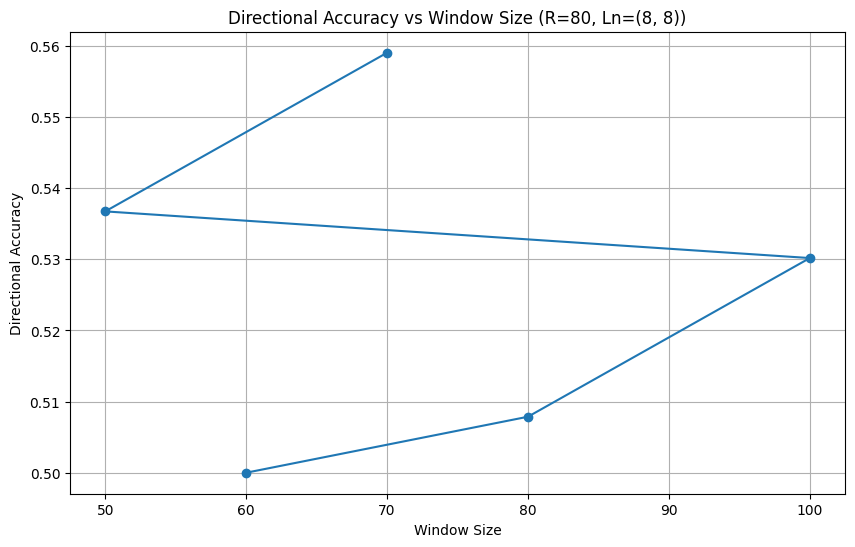

In [10]:
import json
import pandas as pd
import numpy as np
from time import time
from itertools import product
from model.prediction_engine import PredictionTestEngine
from datetime import datetime
from matplotlib import pyplot as plt

# Define hyperparameter grid
window_sizes = [50, 60, 70, 80, 100]
R_values = [10, 20, 30, 40, 60, 80]
Ln_values = [(2,2), (4,4), (8,8), (15,15), (20,20)]

# Prepare to store results
results = []
epsilon = 1e-8  # Fixed epsilon value
n_jobs = 5     # Use 5 parallel jobs for each model fit

# Start timing
start_time = time()

# Total number of combinations to try
total_combinations = len(window_sizes) * len(R_values) * len(Ln_values)
print(f"Running grid search with {total_combinations} combinations...")

# Counter for progress tracking
counter = 0

# Try all combinations
for window_size, R, Ln in product(window_sizes, R_values, Ln_values):
    counter += 1
    print(f"Combination {counter}/{total_combinations}: window_size={window_size}, R={R}, Ln={Ln}")
    
    # Create a new engine for each window size
    engine = PredictionTestEngine(
        X_all,
        Y_all,
        window_size=window_size,
        train_start=int(0.98 * X_all.shape[0]),  # 95% of data for training
        time_index=time_index_all,
    )
    
    try:
        # Run the model with the current hyperparameters
        _, _, _, metrics = engine.run(
            method="hopls", 
            R=R, 
            Ln=Ln, 
            epsilon=epsilon, 
            verbose=False,  # Set to True if you want progress bars
            n_jobs=n_jobs
        )
        
        # Store the results
        result = {
            'window_size': window_size,
            'R': R,
            'Ln': Ln,
            'mse': metrics['mse'],
            'r2': metrics['r2'],
            'directional_accuracy': metrics['directional_accuracy']
        }
        results.append(result)
        
        # Print current result
        print(f"  MSE: {metrics['mse']:.6f}, R2: {metrics['r2']:.6f}, "
              f"Directional Accuracy: {metrics['directional_accuracy']:.6f}")
        
    except Exception as e:
        print(f"Error with window_size={window_size}, R={R}, Ln={Ln}: {e}")
        # Continue with next combination

# Calculate total elapsed time
elapsed_time = time() - start_time
print(f"Grid search completed in {elapsed_time:.2f} seconds.")

# Convert results to DataFrame and sort by directional accuracy (descending)
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('directional_accuracy', ascending=False)

# Save results to JSON
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
json_filename = f"hopls_ridge_gridsearch_results_{timestamp}.json"
with open(json_filename, 'w') as f:
    json.dump(results, f, indent=2)
print(f"Results saved to {json_filename}")

# Print top 10 configurations by directional accuracy
print("\nTop 10 configurations by directional accuracy:")
pd.set_option('display.precision', 6)
pd.set_option('display.max_columns', None)
display(results_df.head(10))

# Plot directional accuracy vs window size for the top R and Ln combination
best_R = results_df.iloc[0]['R']
best_Ln = results_df.iloc[0]['Ln']
best_configs = results_df[(results_df['R'] == best_R) & 
                         (results_df['Ln'] == results_df.iloc[0]['Ln'])]

plt.figure(figsize=(10, 6))
plt.plot(best_configs['window_size'], best_configs['directional_accuracy'], 'o-')
plt.title(f'Directional Accuracy vs Window Size (R={best_R}, Ln={best_Ln})')
plt.xlabel('Window Size')
plt.ylabel('Directional Accuracy')
plt.grid(True)
plt.show()